## Report

 

### Approach and strategy
 
The model we build is based on the RNN network and LSTM layers.Since we deal with a problem of time series with many variables, the approach adopeted is to develop a model to forecast a multivariate time series.

This will allow to use many inputs (all the variables in question in case it is expected to improve the predictions) and enventually other external factors in the future.
    
For churn and leavers variables : each target is predicted alone based only on its own history and price increases' history.
    
For other four variables: each one of them are considered as a multivariate time series.Each variable is predicted using it's own history and the history of others alongside with price increases' record.

 
### Spliting the data set into train and validation :
   
   we take the data prior to 2018-09-01 to train our model.This choice is justified by first by the small size of dataset as well as the objective to prevent on-off shock price in 2018-09-01 to impact and bias our model.
       The task of this challenge consits of prediction of the next 12 month.Which means if we have a large data set, we will use 12-month pediction values and 12-month real values to compute the loss function (rmse and mape) for validation set.But in our case, the size of validation set allows to construct a target future whith a size of 6-months, in addition to this, 

 
### Quantify the impact to not impact our future prediction:

Since our model can handel multivariate series, we add a column `['increase_impact']` to our dataset in which we map the dates with increased price by 1 and others with 0.

when we compute the loss for validation set we don't include the range that hase undergone the impact of on-off shock .


### On-off shock impact on future prediction :

The test split was performed without including this priode between september and december in the training set

In addition to not bias the evaluation of the model, the period that overlaps with the impact of this on-off shock is excluded from the data validation set when computing losses.

We remove periode of the on-off shock that is conidered as anomalie (will not be repeated in the future) which mean that only the last 3 month of the validation will be used to compute the rmse of the model on the validation set.

In [1]:

import os
import time
import datetime
import math
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')


from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf


from helper_functions import multivariate_data, multi_step_plot, plot_train_history,\
                            mean_absolute_percentage_error, create_time_steps, max_absolute_percentage_error, rmse,\
                            create_csv, split_train_test

In [2]:
# get the name of directory and file name to be uploaded
dir_path = '/home/elhassane/Bootcamps/topcoder/CFO_Sandesh_Chalenges/CFO_Sandesh3_Refinement/mycode/datasets'
file_name = 'Privatized_data_Sandesh_Brand_3.xlsx'

In [3]:
# Remove the top two descriptive rows 
df = pd.read_excel(dir_path+"/"+file_name)

In [4]:
#discover the dataset
df.head(2)

,Generic Group,Generic Brand,Generic Product Category,Generic Product,Generic Group variable,Generic Variable,Generic Sub-Variable,Generic LookupKey,Units,14/15_Q1_Apr,...,18/19_Q4_Jan,18/19_Q4_Feb,18/19_Q4_Mar,19/20_Q1_Apr,19/20_Q1_May,19/20_Q1_Jun,19/20_Q2_Jul,19/20_Q2_Aug,19/20_Q2_Sep,19/20_Q3_Oct
0,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,All,Complaints,Sandesh Brand 3 Base Size - Support calculatin...,Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Number,-1.784323,...,1.194388,1.223606,1.235110,x,x,x,x,x,x,x
1,Segment 1 - Market,"Sandesh Brand 1, Sandesh Brand 2, Sandesh Brand 3",Broadband,Rabbit,Footprint,Footprint - Percentage of Total Premises,Intentionally Blank,"Segment 1 - MarketSandesh Brand 1, Sandesh Bra...",Percentage,-2.559847,...,0.918188,0.918188,0.918188,x,x,x,x,NaN,NaN,NaN


In [5]:
# Generic variables to forecasting
TARGET_VARIABLES = [
    'Leavers - Tortoise',
    'Churn - Falcon',
    'Gross Adds - Tortoise',
    'Gross Adds - Falcon',
    'Net Migrations - Tortoise',
    'Net Migrations - Falcon',
]
TARGET_VARIABLES_NORM = [
    'Leavers - Tortoise(norm)',
    'Churn - Falcon(norm)',
    'Gross Adds - Tortoise(norm)',
    'Gross Adds - Falcon(norm)',
    'Net Migrations - Tortoise(norm)',
    'Net Migrations - Falcon(norm)',
]


# the brand of the challenge
BRAND = 'Sandesh Brand 3'


   ### Selecting the 6 normalised  target variables 

In [6]:
# Select the target variables under the scope of the challeng
df = df[(df['Generic Brand'] == BRAND) & (df.apply(lambda x: x['Generic Variable'] in TARGET_VARIABLES_NORM, axis=1)==True)]
df.head(6)

,Generic Group,Generic Brand,Generic Product Category,Generic Product,Generic Group variable,Generic Variable,Generic Sub-Variable,Generic LookupKey,Units,14/15_Q1_Apr,...,18/19_Q4_Jan,18/19_Q4_Feb,18/19_Q4_Mar,19/20_Q1_Apr,19/20_Q1_May,19/20_Q1_Jun,19/20_Q2_Jul,19/20_Q2_Aug,19/20_Q2_Sep,19/20_Q3_Oct
91,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Tortoise,Volume,Net Migrations - Tortoise(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,2.264996,...,-0.758131,-1.194424,-1.051361,x,x,x,x,x,x,x
92,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Net Migrations - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-2.264996,...,0.758131,1.194424,1.051361,x,x,x,x,x,x,x
93,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Tortoise,Volume,Gross Adds - Tortoise(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,0.741010,...,-0.347920,-0.217595,-0.698893,x,x,x,x,x,x,x
94,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Gross Adds - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-1.647151,...,1.123166,1.254846,0.952848,x,x,x,x,x,x,x
95,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Tortoise,Volume,Leavers - Tortoise(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-0.818887,...,-0.114919,0.968960,0.598707,x,x,x,x,x,x,x
96,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Churn - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-1.103517,...,1.140796,1.919236,1.770374,x,x,x,x,x,x,x


In [7]:
# Transpose tha table
df = df.transpose()

In [8]:
df.head(10)

,91,92,93,94,95,96
Generic Group,Segment 1 - Sandesh Brand 3,Segment 1 - Sandesh Brand 3,Segment 1 - Sandesh Brand 3,Segment 1 - Sandesh Brand 3,Segment 1 - Sandesh Brand 3,Segment 1 - Sandesh Brand 3
Generic Brand,Sandesh Brand 3,Sandesh Brand 3,Sandesh Brand 3,Sandesh Brand 3,Sandesh Brand 3,Sandesh Brand 3
Generic Product Category,Broadband,Broadband,Broadband,Broadband,Broadband,Broadband
Generic Product,Tortoise,Falcon,Tortoise,Falcon,Tortoise,Falcon
Generic Group variable,Volume,Volume,Volume,Volume,Volume,Volume
Generic Variable,Net Migrations - Tortoise(norm),Net Migrations - Falcon(norm),Gross Adds - Tortoise(norm),Gross Adds - Falcon(norm),Leavers - Tortoise(norm),Churn - Falcon(norm)
Generic Sub-Variable,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank
Generic LookupKey,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...
Units,(000)s,(000)s,(000)s,(000)s,(000)s,(000)s
14/15_Q1_Apr,2.265,-2.265,0.74101,-1.64715,-0.818887,-1.10352


In [9]:
# Set generic lookupkey as the new column name
df.columns = df.loc['Generic LookupKey']

In [10]:
# remove unwanted data to consutruct clean time series
df= df[9:]

In [11]:
df.head()

Generic LookupKey,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
14/15_Q1_Apr,2.265,-2.265,0.74101,-1.64715,-0.818887,-1.10352
14/15_Q1_May,2.01244,-2.01244,1.73163,-1.7238,0.474437,-1.0767
14/15_Q1_Jun,2.51521,-2.51521,-0.348146,-1.81242,-2.22229,-1.12865
14/15_Q2_Jul,2.17821,-2.17821,0.171874,-1.54335,-0.897429,-1.08591
14/15_Q2_Aug,1.16507,-1.16507,1.08679,-1.04162,0.6769,-1.00005


In [12]:
# Rename row index as 'Timestamp' 
df = df.rename_axis('Timestamp').reset_index()

In [13]:
df.head(2)

Generic LookupKey,Timestamp,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
0,14/15_Q1_Apr,2.265,-2.265,0.74101,-1.64715,-0.818887,-1.10352
1,14/15_Q1_May,2.01244,-2.01244,1.73163,-1.7238,0.474437,-1.0767


In [14]:
# Now the name of the index becomes 'Generic LookupKey', remove it
df.columns.name = None

In [15]:
df.head(2)

,Timestamp,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
0,14/15_Q1_Apr,2.265,-2.265,0.74101,-1.64715,-0.818887,-1.10352
1,14/15_Q1_May,2.01244,-2.01244,1.73163,-1.7238,0.474437,-1.0767


In [16]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
Timestamp                                                                               67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise    67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon        67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise        67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon            67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise           67 non-null object
Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon                 67 non-null object
dtypes: object(7)
memory usage: 3.8+ KB


     Data types are objets, let's correct this :

### Correct the type of data

### Correct type of the Timestamp:
    
    *Transform Timestamp into datetime type:*
     The first index (14/15_Q1_Apr) of the range: 2014-04-01 first quarter 
     The last index (19/20_Q3_Oct) of the range :2019-10-01

In [17]:
# set a datetime index to df
index_min ='2014-04-01' # the first date in dataset
index_max = '2019-10-01' # the last date in dataset
timestamp = pd.date_range(start=index_min, end=index_max, freq='MS')

In [18]:
# check
len(timestamp)-len(df)

0

In [19]:
# set the index with the datetime index
df = df.set_index(timestamp)

In [20]:
df.head(3)

,Timestamp,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
2014-04-01,14/15_Q1_Apr,2.265,-2.265,0.74101,-1.64715,-0.818887,-1.10352
2014-05-01,14/15_Q1_May,2.01244,-2.01244,1.73163,-1.7238,0.474437,-1.0767
2014-06-01,14/15_Q1_Jun,2.51521,-2.51521,-0.348146,-1.81242,-2.22229,-1.12865


In [21]:
#drop timestamp column
df.drop(columns='Timestamp', inplace=True)

In [22]:
#replace x with nan value
df=df.replace('x', np.nan)

In [23]:
#Check
df.tail(10)

,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
2019-01-01,-0.758131,0.758131,-0.347920,1.123166,-0.114919,1.140796
2019-02-01,-1.194424,1.194424,-0.217595,1.254846,0.968960,1.919236
2019-03-01,-1.051361,1.051361,-0.698893,0.952848,0.598707,1.770374
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Correct data types
df = df.astype(float)

# Check
df.dtypes.value_counts()

float64    6
dtype: int64

### Impact of regular increases 


Impact of regular increases is factored into the model by adding a column to the dataset in which we map these increases.The model with the approache of multivariate series we have adopted will learn their impact on the future predictions.

 
                         

In [25]:
# add column that map price incrases 
# 0 => no increase
# 1 => increase
df['price_increase']=pd.DataFrame(np.zeros(len(df)), index=df.index)

In [26]:
#fill the column with values given what is given in topic
df.loc['2015-09-01','price_increase']=1
df.loc['2016-09-01','price_increase']=1
df.loc['2017-07-01','price_increase']=1
df.loc['2018-06-01','price_increase']=1
df.loc['2018-09-01','price_increase']=1

In [27]:
#check
df.columns

Index(['Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon',
       'price_increase'],
      dtype='object')

   ###  Dataset visualisation 

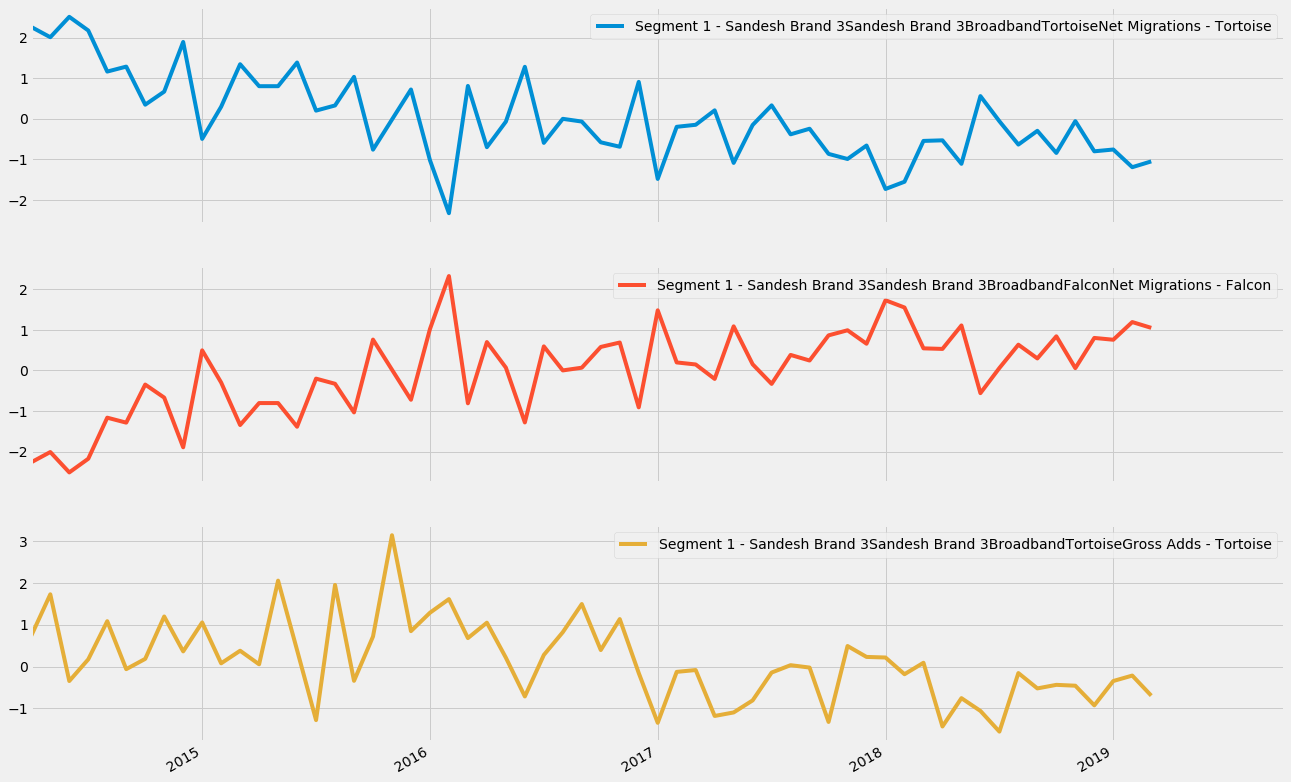

In [28]:
# plot variable product
_ = df.iloc[:,:3].plot(figsize=(20,15), subplots=True, grid=True)

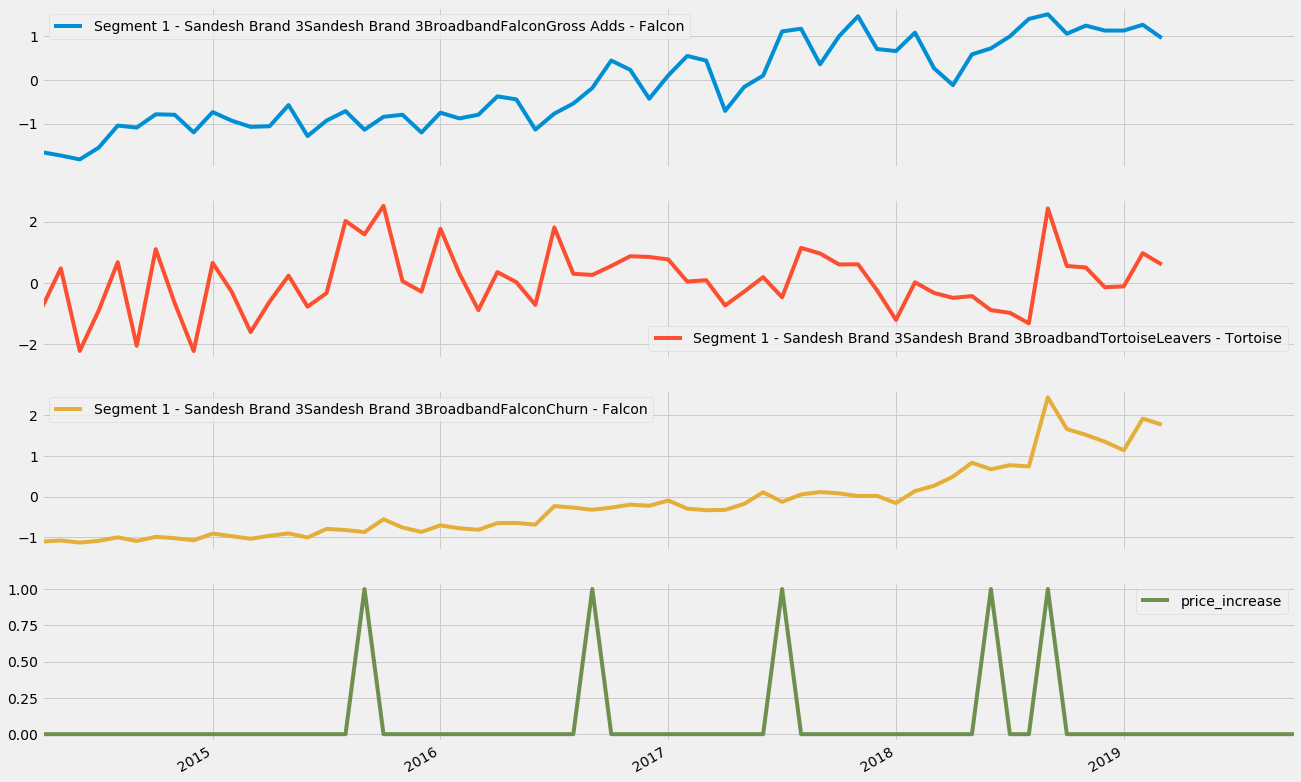

In [32]:
# plot variable product
_ = df.iloc[:,3:7].plot(figsize=(20,15), subplots= True, grid=True)

In [29]:
# Remove NAN values in the end of training set (7 values in each column)
df=df.dropna()

In [30]:
#check
df.tail(3)

,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon,price_increase
2019-01-01,-0.758131,0.758131,-0.347920,1.123166,-0.114919,1.140796,0.0
2019-02-01,-1.194424,1.194424,-0.217595,1.254846,0.968960,1.919236,0.0
2019-03-01,-1.051361,1.051361,-0.698893,0.952848,0.598707,1.770374,0.0


### Ensure reproducible results

Since the model was trainded on the GPU version of tensorfolw, it is expected to still have some uncontrolled source of randomness.

In [31]:
# set random seed for reproducible results
from numpy.random import seed
tf.random.set_seed(10)
seed(1)


### Buil the model with multivariate time series approach


In [32]:
#the generic_lockup_variables from entire dataset
generic_lockup_variables_df=df.columns
generic_lockup_variables_df

Index(['Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon',
       'price_increase'],
      dtype='object')

In [42]:


def make_prediction(df, date_train_val_split='2018-08-01', epochs=50, batch_size=12, on_off_periode_removed = True, price_increase_added = True, scale_ = True,
                    past_history= 3, future_target= 12, verbose=2 ):
    ''''
    This model make prediction of 'future_target' month based on the most recent 'past_history' month data 
     available in the df provided to it.
     
    input : * df :dataframne, the dataset with target variables
            * epochs :integer, number of epochs for training
            * batch_size : integer, size of the batch to use in fitting the model 
            * on_off_periode_removed : True if remove 
              the periode with on-off shock impact from the evaluation set when computing losses to evaluate the model
            * price_increase_added True if   the price increase was added to df
            * scale_ True if we want to feed the model with scaled data using MinMaxScaler
            * past_history : window in the past to use to predict the furtur_target
            * future_target : the nomber of month to predict
            * verbose : integer, display training progression of the model
            
            
    output :
            * forcast_challenge :list of arrays, all predictions for the generic lockup variables in df
            * forcasts_test: list of arrays, all predictions for validation set for the generic lockup variables in df
            * RMSE: list of float, rmse on validation set of each model used to predict a given generic lockup variable
            * MAPE: list of float, MAPE on validation set of each model used to predict a given generic lockup variable
            * models_history: list of arrays, array of recorded training losses during fiting model for generic lockup variable 
    '''
    
    
    #get the name of generic lockup variables from df 
    generic_lockup_variables = df.columns

    # split df into df_train and df_val
    df_train, df_val = split_train_test(df, date_train_val_split)

    #dataset = df[[generic_lockup_variables[0], 'price_increase']].values

    generic_lockup_variables = df_train.columns


    if scale_ == True:
        # convert df to numpy array
        #dataset = df.values
        # standrdize the dataset using MinMaxScaler()
        Scaler = MinMaxScaler()
        Scale = Scaler.fit(df_train.values)
        df_train = Scale.transform(df_train.values)
        df_val = Scale.transform(df_val.values)
        dataset = Scale.transform(df.values) # will be used to forcast the challenge period

    else: 
        # convert to numpy array
        df_train = df_train.values 
        df_val = df_val.values
        dataset = df.values

    #challenge to forcast
    forcast_challenge=[]

    #list of forcasted variables
    forcasts_test = []

    #list of model results : to plot losses
    models_history = []

    #losses calculted for each target (generic lockup variable)
    RMSE = []
    MAPE = []

    # initiat a timer to estimate the training time
    tmp = time.time()

    # lenght of variables(generic lockup variables) to iterate and predict

    if price_increase_added == True :
        indexes_lenght =len(generic_lockup_variables)-1
    else:
        indexes_lenght = len(generic_lockup_variables)


    for index in range(indexes_lenght):


        # target index : index of the generic lockup variable to be predicted range(1,7)
        target_index = index

        x_train_multi, y_train_multi = multivariate_data(df_train, df_train[:, target_index], 0,
                                                           None, past_history,
                                                           future_target,
                                                           single_step=False)


        x_val_multi, y_val_multi = multivariate_data(df_val, df_val[:, target_index],
                                                     0, None, past_history,
                                                     future_target)


        # Use batchs and buffer for future use in case in large data set
        BATCH_SIZE = batch_size
        BUFFER_SIZE = 10000

        # Build dataset objects : tensor pipline
        train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
        val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

        # Buil the model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(LSTM(16, activation='relu'))
        multi_step_model.add(Dense(future_target))
        multi_step_model.compile(optimizer='adam', loss='mean_squared_error') #tf.keras.optimizers.RMSprop(clipvalue=1.0)

        # fit the model
        EPOCHS=epochs #epochs[index]
        batch_number = len(x_train_multi)/ BATCH_SIZE
        steps_per_epoch = math.ceil(batch_number)

        multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, verbose=verbose, )

        #conserve the training curve for analysis
        models_history.append(multi_step_history)


        #make prediction
        y_predicted = multi_step_model.predict(x_val_multi)


        ##invert scaling for past_history=3 and future_target=12
        if scale_ == True:

            #invert scaling for acctual
            rt=pd.DataFrame(df_val[past_history:]) 
            acctual_scaled_name = generic_lockup_variables[target_index]+'_scaled'# add the column we want to invert the scaling for
            rt.iloc[:,target_index] = pd.DataFrame(y_val_multi[:1].reshape(future_target,1),columns=[acctual_scaled_name])
            inv_yhat = Scaler.inverse_transform(rt.values)
            inv_y_val_multi = inv_yhat[:,target_index]


            # invert scaling for forcast
            rt=pd.DataFrame(df_val[past_history:]) 
            forcast_scaled_name = generic_lockup_variables[target_index]+'_scaled_forcast'
            rt.iloc[:,target_index]= pd.DataFrame(y_predicted[:1].reshape(future_target,1), columns=[forcast_scaled_name])
            inv_yhat = Scaler.inverse_transform(rt.values)
            inv_predicted = inv_yhat[:,target_index]

            #append the prediction in the forcast lists
            forcasts_test.append(inv_predicted)

            #make prediction for the periode in the challenge
            x_challenge = dataset[-past_history:].reshape(1,past_history,len(generic_lockup_variables))
            challenge_prediction = multi_step_model.predict(x_challenge)

            # invert scaling for challenge forcast
            rt=pd.DataFrame(df_val[past_history:]) 
            forcast_scaled_name = generic_lockup_variables[target_index]+'_scaled_forcast'
            rt.iloc[:,target_index]= pd.DataFrame(challenge_prediction[:1].reshape(future_target,1), columns=[forcast_scaled_name])
            inv_yhat = Scaler.inverse_transform(rt.values)
            inv_challenge_prediction = inv_yhat[:,target_index]

            forcast_challenge.append(inv_challenge_prediction)

            ##compute the losse after inverting scaling


            if on_off_periode_removed == True:

                rmse_loss = rmse(inv_y_val_multi[4:7],inv_predicted[4:7])
                mape_loss = mean_absolute_percentage_error(inv_y_val_multi[4:7],inv_predicted[4:7])

            else:
                #we remove the nan values to calculate the rmse and mape
                messing_values = np.isnan(inv_y_val_multi).sum()
                lenght = len(inv_y_val_multi)-messing_values
                rmse_loss = rmse(inv_y_val_multi[:lenght],inv_predicted[:lenght])
                mape_loss = mean_absolute_percentage_error(inv_y_val_multi[:lenght],inv_predicted[:lenght])



        else:

            forcasts_test.append(y_predicted)

            if on_off_periode_removed == True:
                rmse_loss = rmse(y_val_multi[:1][0][4:7],y_predicted[:1][0][4:7]) #old value [0][:6]
                mape_loss = mean_absolute_percentage_error(y_val_multi[:1][0][4:7],y_predicted[:1][0][4:7])

            else:
                messing_values = np.isnan(y_val_multi[:1][0]).sum()
                lenght = len(inv_y_val_multi)-messing_values

                rmse_loss = rmse(y_val_multi[:1][0][:lenght],y_predicted[:1][0][:lenght]) #old value [0][:6]
                mape_loss = mean_absolute_percentage_error(y_val_multi[:1][0][:lenght],y_predicted[:1][0][:lenght])

            x_challenge = dataset[-past_history:].reshape(1,past_history,len(generic_lockup_variables))
            challenge_prediction = multi_step_model.predict(x_challenge)
            forcast_challenge.append(challenge_prediction)


        RMSE.append(rmse_loss)

        MAPE.append(mape_loss)



        print('\n')
        print('#####  Model report   #######:')
        print('\n')

        print(generic_lockup_variables[target_index])
        print( 'MAPE Validation set : %.3f' % mape_loss)
        print('RMSE Validatin set  : %.3f' % rmse_loss )

        print('\n')

    print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))
    
    return  forcast_challenge, forcasts_test, RMSE, MAPE, models_history

  ### Falcon Churn

In [38]:
# Falcon Churn:
generic_lockup_variables_df=df.columns
#each variable will be predicted alone
df_falcon_churn =df[[generic_lockup_variables_df[5], 'price_increase']]
forcast_falcon_churn, _, rmse_fal_chu, mape_fal_chu, models_history_fal_chu = make_prediction(df_falcon_churn, epochs=80, batch_size=24, on_off_periode_removed = True,
                                                                price_increase_added= True, scale_= True)   

Train for 2 steps
Epoch 1/80
2/2 - 34s - loss: 0.1812
Epoch 2/80
2/2 - 0s - loss: 0.1767
Epoch 3/80
2/2 - 0s - loss: 0.1713
Epoch 4/80
2/2 - 0s - loss: 0.1632
Epoch 5/80
2/2 - 0s - loss: 0.1755
Epoch 6/80
2/2 - 0s - loss: 0.1644
Epoch 7/80
2/2 - 0s - loss: 0.1640
Epoch 8/80
2/2 - 0s - loss: 0.1558
Epoch 9/80
2/2 - 0s - loss: 0.1579
Epoch 10/80
2/2 - 0s - loss: 0.1615
Epoch 11/80
2/2 - 0s - loss: 0.1506
Epoch 12/80
2/2 - 0s - loss: 0.1505
Epoch 13/80
2/2 - 0s - loss: 0.1534
Epoch 14/80
2/2 - 0s - loss: 0.1484
Epoch 15/80
2/2 - 0s - loss: 0.1513
Epoch 16/80
2/2 - 0s - loss: 0.1417
Epoch 17/80
2/2 - 0s - loss: 0.1496
Epoch 18/80
2/2 - 0s - loss: 0.1366
Epoch 19/80
2/2 - 0s - loss: 0.1437
Epoch 20/80
2/2 - 0s - loss: 0.1301
Epoch 21/80
2/2 - 0s - loss: 0.1320
Epoch 22/80
2/2 - 0s - loss: 0.1303
Epoch 23/80
2/2 - 0s - loss: 0.1282
Epoch 24/80
2/2 - 0s - loss: 0.1254
Epoch 25/80
2/2 - 0s - loss: 0.1174
Epoch 26/80
2/2 - 0s - loss: 0.1162
Epoch 27/80
2/2 - 0s - loss: 0.1058
Epoch 28/80
2/2 - 

In [37]:
#Repeat Evaluation Experiments
repeats=range(10)
scores_rmse = list()
scores_mape = list()
for i in repeats:
    print('repeate {}'.format(i))
    
    forcast_tortoise_leavers, _, rmse_tor_leav, mape_tor_leav, models_history_tor_leav = make_prediction(df_trotoise_leavers, epochs=80, batch_size=12, 
                                                                                 on_off_periode_removed = True,
                                                                                 price_increase_added = True, scale_ = True)
    scores_rmse.append(rmse_tor_leav)
    scores_mape.append(mape_tor_leav)

repeate 0
Train for 4 steps
Epoch 1/80
4/4 - 25s - loss: 0.2998
Epoch 2/80
4/4 - 0s - loss: 0.2977
Epoch 3/80
4/4 - 0s - loss: 0.2931
Epoch 4/80
4/4 - 0s - loss: 0.2790
Epoch 5/80
4/4 - 0s - loss: 0.2839
Epoch 6/80
4/4 - 0s - loss: 0.2616
Epoch 7/80
4/4 - 0s - loss: 0.2616
Epoch 8/80
4/4 - 0s - loss: 0.2481
Epoch 9/80
4/4 - 0s - loss: 0.2375
Epoch 10/80
4/4 - 0s - loss: 0.2308
Epoch 11/80
4/4 - 0s - loss: 0.2133
Epoch 12/80
4/4 - 0s - loss: 0.1864
Epoch 13/80
4/4 - 0s - loss: 0.1722
Epoch 14/80
4/4 - 0s - loss: 0.1577
Epoch 15/80
4/4 - 0s - loss: 0.1422
Epoch 16/80
4/4 - 0s - loss: 0.1237
Epoch 17/80
4/4 - 0s - loss: 0.1137
Epoch 18/80
4/4 - 0s - loss: 0.0939
Epoch 19/80
4/4 - 0s - loss: 0.0894
Epoch 20/80
4/4 - 0s - loss: 0.0809
Epoch 21/80
4/4 - 0s - loss: 0.0724
Epoch 22/80
4/4 - 0s - loss: 0.0624
Epoch 23/80
4/4 - 0s - loss: 0.0624
Epoch 24/80
4/4 - 0s - loss: 0.0619
Epoch 25/80
4/4 - 0s - loss: 0.0541
Epoch 26/80
4/4 - 0s - loss: 0.0499
Epoch 27/80
4/4 - 0s - loss: 0.0517
Epoch 28

Epoch 55/80
4/4 - 0s - loss: 0.0406
Epoch 56/80
4/4 - 0s - loss: 0.0402
Epoch 57/80
4/4 - 0s - loss: 0.0404
Epoch 58/80
4/4 - 0s - loss: 0.0451
Epoch 59/80
4/4 - 0s - loss: 0.0450
Epoch 60/80
4/4 - 0s - loss: 0.0423
Epoch 61/80
4/4 - 0s - loss: 0.0403
Epoch 62/80
4/4 - 0s - loss: 0.0421
Epoch 63/80
4/4 - 0s - loss: 0.0421
Epoch 64/80
4/4 - 0s - loss: 0.0428
Epoch 65/80
4/4 - 0s - loss: 0.0383
Epoch 66/80
4/4 - 0s - loss: 0.0408
Epoch 67/80
4/4 - 0s - loss: 0.0427
Epoch 68/80
4/4 - 0s - loss: 0.0402
Epoch 69/80
4/4 - 0s - loss: 0.0413
Epoch 70/80
4/4 - 0s - loss: 0.0426
Epoch 71/80
4/4 - 0s - loss: 0.0407
Epoch 72/80
4/4 - 0s - loss: 0.0373
Epoch 73/80
4/4 - 0s - loss: 0.0369
Epoch 74/80
4/4 - 0s - loss: 0.0405
Epoch 75/80
4/4 - 0s - loss: 0.0399
Epoch 76/80
4/4 - 0s - loss: 0.0418
Epoch 77/80
4/4 - 0s - loss: 0.0400
Epoch 78/80
4/4 - 0s - loss: 0.0390
Epoch 79/80
4/4 - 0s - loss: 0.0368
Epoch 80/80
4/4 - 0s - loss: 0.0417


#####  Model report   #######:


Segment 1 - Sandesh Brand 3Sa

Epoch 23/80
4/4 - 0s - loss: 0.0576
Epoch 24/80
4/4 - 0s - loss: 0.0534
Epoch 25/80
4/4 - 0s - loss: 0.0534
Epoch 26/80
4/4 - 0s - loss: 0.0510
Epoch 27/80
4/4 - 0s - loss: 0.0491
Epoch 28/80
4/4 - 0s - loss: 0.0490
Epoch 29/80
4/4 - 0s - loss: 0.0468
Epoch 30/80
4/4 - 1s - loss: 0.0425
Epoch 31/80
4/4 - 0s - loss: 0.0441
Epoch 32/80
4/4 - 0s - loss: 0.0470
Epoch 33/80
4/4 - 0s - loss: 0.0465
Epoch 34/80
4/4 - 0s - loss: 0.0444
Epoch 35/80
4/4 - 0s - loss: 0.0480
Epoch 36/80
4/4 - 0s - loss: 0.0399
Epoch 37/80
4/4 - 0s - loss: 0.0437
Epoch 38/80
4/4 - 0s - loss: 0.0481
Epoch 39/80
4/4 - 0s - loss: 0.0411
Epoch 40/80
4/4 - 0s - loss: 0.0425
Epoch 41/80
4/4 - 0s - loss: 0.0432
Epoch 42/80
4/4 - 0s - loss: 0.0412
Epoch 43/80
4/4 - 0s - loss: 0.0394
Epoch 44/80
4/4 - 0s - loss: 0.0414
Epoch 45/80
4/4 - 0s - loss: 0.0417
Epoch 46/80
4/4 - 0s - loss: 0.0426
Epoch 47/80
4/4 - 0s - loss: 0.0387
Epoch 48/80
4/4 - 0s - loss: 0.0413
Epoch 49/80
4/4 - 0s - loss: 0.0433
Epoch 50/80
4/4 - 0s - loss:

4/4 - 0s - loss: 0.0416
Epoch 78/80
4/4 - 0s - loss: 0.0420
Epoch 79/80
4/4 - 0s - loss: 0.0369
Epoch 80/80
4/4 - 0s - loss: 0.0405


#####  Model report   #######:


Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise
MAPE Validation set : 135.634
RMSE Validatin set  : 0.917


GPU Training Time: 56.75943183898926 seconds
repeate 8
Train for 4 steps
Epoch 1/80
4/4 - 27s - loss: 0.3089
Epoch 2/80
4/4 - 0s - loss: 0.2953
Epoch 3/80
4/4 - 0s - loss: 0.2715
Epoch 4/80
4/4 - 0s - loss: 0.2668
Epoch 5/80
4/4 - 0s - loss: 0.2650
Epoch 6/80
4/4 - 0s - loss: 0.2509
Epoch 7/80
4/4 - 0s - loss: 0.2384
Epoch 8/80
4/4 - 0s - loss: 0.2294
Epoch 9/80
4/4 - 0s - loss: 0.2097
Epoch 10/80
4/4 - 0s - loss: 0.2012
Epoch 11/80
4/4 - 0s - loss: 0.1746
Epoch 12/80
4/4 - 0s - loss: 0.1496
Epoch 13/80
4/4 - 0s - loss: 0.1244
Epoch 14/80
4/4 - 0s - loss: 0.1051
Epoch 15/80
4/4 - 0s - loss: 0.0763
Epoch 16/80
4/4 - 0s - loss: 0.0782
Epoch 17/80
4/4 - 0s - loss: 0.0609
Epoch 18/80
4/4 - 

In [92]:

mean_skill = sum(scores_rmse) / count(scores_rmse)
mean_skill 

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [105]:
len(scores_rmse)

TypeError: object of type 'float' has no len()

In [38]:
sum_scores_mape=0
for i in range(len(scores_mape)):
    sum_scores_mape+=scores_mape[i][0]

In [39]:
mean_skill =  sum_scores_mape / len(scores_mape)
mean_skill 

195.46606149166718

In [ ]:
# Repeat Evaluation Experiments + k-fold cross validation
repeats=range(5)
scores = list()
for i in repeats:
    run_scores = list()
    for j in k:
        train, test = split_old(data, j)
        model = fit(train.X, train.y)
        predictions = model.predict(test.X)
        skill = compare(test.y, predictions)
        run_scores.append(skill)
    scores.append(mean(run_scores))


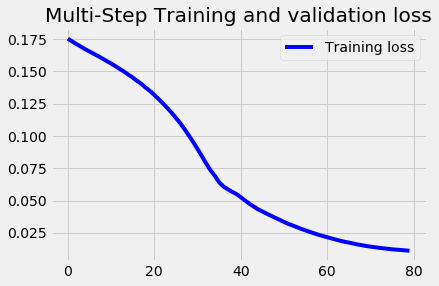

In [39]:
# plot the training losses
plot_train_history(models_history_fal_chu[0], 'Multi-Step Training and validation loss')

 
 ### Tortoise leavers:

In [43]:

    
#get the column with the generic lockup variable 'Tortoise leavers' and 'price_increase'
df_trotoise_leavers =df[[generic_lockup_variables_df[4], 'price_increase']]
columns_names= df_trotoise_leavers.columns[:-1]
#make prediction
forcast_tortoise_leavers, _, rmse_tor_leav, mape_tor_leav, models_history_tor_leav = make_prediction(df_trotoise_leavers, epochs=300, batch_size=12, 
                                                                                 on_off_periode_removed = True,
                                                                                 price_increase_added = True, scale_ = True)



Train for 4 steps
Epoch 1/300
4/4 - 26s - loss: 0.3050
Epoch 2/300
4/4 - 0s - loss: 0.2907
Epoch 3/300
4/4 - 0s - loss: 0.2811
Epoch 4/300
4/4 - 0s - loss: 0.2678
Epoch 5/300
4/4 - 0s - loss: 0.2632
Epoch 6/300
4/4 - 0s - loss: 0.2459
Epoch 7/300
4/4 - 0s - loss: 0.2483
Epoch 8/300
4/4 - 0s - loss: 0.2246
Epoch 9/300
4/4 - 0s - loss: 0.2139
Epoch 10/300
4/4 - 0s - loss: 0.1905
Epoch 11/300
4/4 - 0s - loss: 0.1733
Epoch 12/300
4/4 - 0s - loss: 0.1526
Epoch 13/300
4/4 - 0s - loss: 0.1271
Epoch 14/300
4/4 - 0s - loss: 0.1056
Epoch 15/300
4/4 - 0s - loss: 0.0995
Epoch 16/300
4/4 - 0s - loss: 0.0974
Epoch 17/300
4/4 - 0s - loss: 0.0755
Epoch 18/300
4/4 - 0s - loss: 0.0734
Epoch 19/300
4/4 - 0s - loss: 0.0696
Epoch 20/300
4/4 - 0s - loss: 0.0664
Epoch 21/300
4/4 - 0s - loss: 0.0578
Epoch 22/300
4/4 - 0s - loss: 0.0576
Epoch 23/300
4/4 - 0s - loss: 0.0477
Epoch 24/300
4/4 - 0s - loss: 0.0517
Epoch 25/300
4/4 - 0s - loss: 0.0481
Epoch 26/300
4/4 - 0s - loss: 0.0471
Epoch 27/300
4/4 - 0s - loss

Epoch 219/300
4/4 - 0s - loss: 0.0390
Epoch 220/300
4/4 - 0s - loss: 0.0378
Epoch 221/300
4/4 - 0s - loss: 0.0378
Epoch 222/300
4/4 - 0s - loss: 0.0377
Epoch 223/300
4/4 - 0s - loss: 0.0424
Epoch 224/300
4/4 - 0s - loss: 0.0393
Epoch 225/300
4/4 - 0s - loss: 0.0378
Epoch 226/300
4/4 - 0s - loss: 0.0387
Epoch 227/300
4/4 - 0s - loss: 0.0375
Epoch 228/300
4/4 - 0s - loss: 0.0375
Epoch 229/300
4/4 - 0s - loss: 0.0378
Epoch 230/300
4/4 - 0s - loss: 0.0388
Epoch 231/300
4/4 - 0s - loss: 0.0375
Epoch 232/300
4/4 - 0s - loss: 0.0382
Epoch 233/300
4/4 - 0s - loss: 0.0395
Epoch 234/300
4/4 - 0s - loss: 0.0348
Epoch 235/300
4/4 - 0s - loss: 0.0392
Epoch 236/300
4/4 - 0s - loss: 0.0360
Epoch 237/300
4/4 - 0s - loss: 0.0370
Epoch 238/300
4/4 - 0s - loss: 0.0394
Epoch 239/300
4/4 - 0s - loss: 0.0366
Epoch 240/300
4/4 - 0s - loss: 0.0381
Epoch 241/300
4/4 - 0s - loss: 0.0401
Epoch 242/300
4/4 - 0s - loss: 0.0397
Epoch 243/300
4/4 - 0s - loss: 0.0395
Epoch 244/300
4/4 - 0s - loss: 0.0362
Epoch 245/30

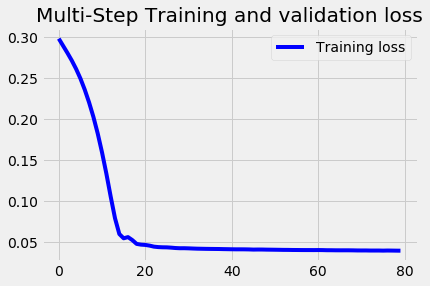

In [41]:
plot_train_history(models_history_tor_leav[0], 'Multi-Step Training and validation loss')

   
   ## Forcast the rest of variables 
   
 The rest of variables:
 
     Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise
     Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon
     Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise
     Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon

In [75]:
# predict the rest of variables

#get the column without the generic lockup variable 'Tortoise leavers' and 'price_increase'
df_rest =df.drop(labels=[df.columns[4],df.columns[5]], axis=1)

#make prediction
forcast_rest, _, rmse_rest, mape_rest, models_history_rest = make_prediction(df_rest, epochs=100, batch_size=60, 
                                                                                 on_off_periode_removed = True,
                                                                                 price_increase_added = True, scale_ = True)



Train for 1 steps
Epoch 1/100
1/1 - 23s - loss: 0.2431
Epoch 2/100
1/1 - 0s - loss: 0.2399
Epoch 3/100
1/1 - 0s - loss: 0.2370
Epoch 4/100
1/1 - 0s - loss: 0.2341
Epoch 5/100
1/1 - 0s - loss: 0.2312
Epoch 6/100
1/1 - 0s - loss: 0.2284
Epoch 7/100
1/1 - 0s - loss: 0.2256
Epoch 8/100
1/1 - 0s - loss: 0.2229
Epoch 9/100
1/1 - 0s - loss: 0.2201
Epoch 10/100
1/1 - 0s - loss: 0.2175
Epoch 11/100
1/1 - 0s - loss: 0.2149
Epoch 12/100
1/1 - 0s - loss: 0.2123
Epoch 13/100
1/1 - 0s - loss: 0.2097
Epoch 14/100
1/1 - 0s - loss: 0.2071
Epoch 15/100
1/1 - 0s - loss: 0.2044
Epoch 16/100
1/1 - 0s - loss: 0.2017
Epoch 17/100
1/1 - 0s - loss: 0.1988
Epoch 18/100
1/1 - 0s - loss: 0.1960
Epoch 19/100
1/1 - 0s - loss: 0.1930
Epoch 20/100
1/1 - 0s - loss: 0.1900
Epoch 21/100
1/1 - 0s - loss: 0.1869
Epoch 22/100
1/1 - 0s - loss: 0.1837
Epoch 23/100
1/1 - 0s - loss: 0.1804
Epoch 24/100
1/1 - 0s - loss: 0.1770
Epoch 25/100
1/1 - 0s - loss: 0.1736
Epoch 26/100
1/1 - 0s - loss: 0.1700
Epoch 27/100
1/1 - 0s - loss

Epoch 12/100
1/1 - 0s - loss: 0.1809
Epoch 13/100
1/1 - 0s - loss: 0.1795
Epoch 14/100
1/1 - 0s - loss: 0.1781
Epoch 15/100
1/1 - 0s - loss: 0.1767
Epoch 16/100
1/1 - 0s - loss: 0.1753
Epoch 17/100
1/1 - 0s - loss: 0.1738
Epoch 18/100
1/1 - 0s - loss: 0.1723
Epoch 19/100
1/1 - 0s - loss: 0.1707
Epoch 20/100
1/1 - 0s - loss: 0.1692
Epoch 21/100
1/1 - 0s - loss: 0.1675
Epoch 22/100
1/1 - 0s - loss: 0.1658
Epoch 23/100
1/1 - 0s - loss: 0.1641
Epoch 24/100
1/1 - 0s - loss: 0.1623
Epoch 25/100
1/1 - 0s - loss: 0.1604
Epoch 26/100
1/1 - 0s - loss: 0.1585
Epoch 27/100
1/1 - 0s - loss: 0.1565
Epoch 28/100
1/1 - 0s - loss: 0.1544
Epoch 29/100
1/1 - 0s - loss: 0.1524
Epoch 30/100
1/1 - 0s - loss: 0.1502
Epoch 31/100
1/1 - 0s - loss: 0.1481
Epoch 32/100
1/1 - 0s - loss: 0.1459
Epoch 33/100
1/1 - 0s - loss: 0.1436
Epoch 34/100
1/1 - 0s - loss: 0.1413
Epoch 35/100
1/1 - 0s - loss: 0.1390
Epoch 36/100
1/1 - 0s - loss: 0.1367
Epoch 37/100
1/1 - 0s - loss: 0.1343
Epoch 38/100
1/1 - 0s - loss: 0.1320
E

In [96]:
generic_lockup_variables

Index(['Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon',
       'price_increase'],
      dtype='object')

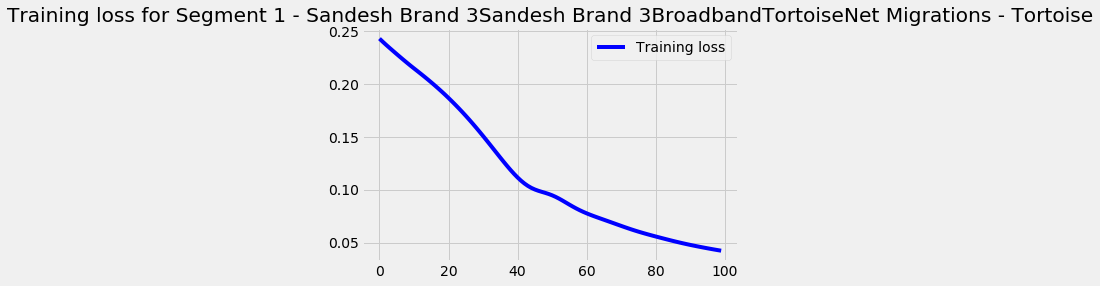

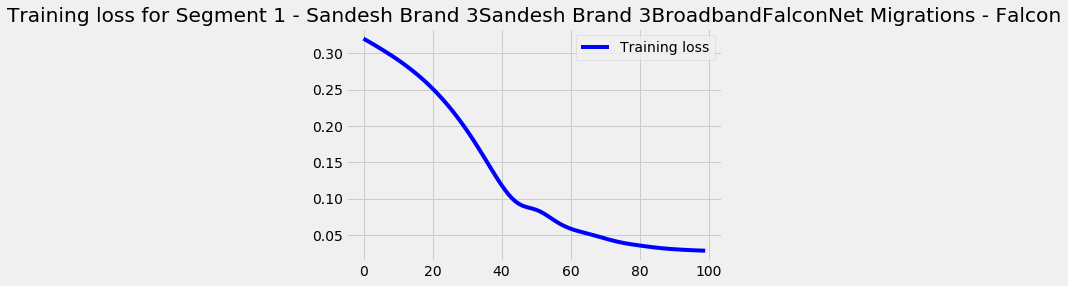

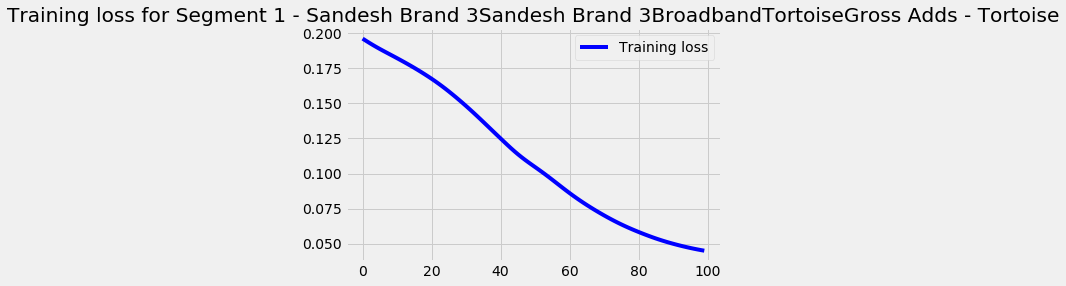

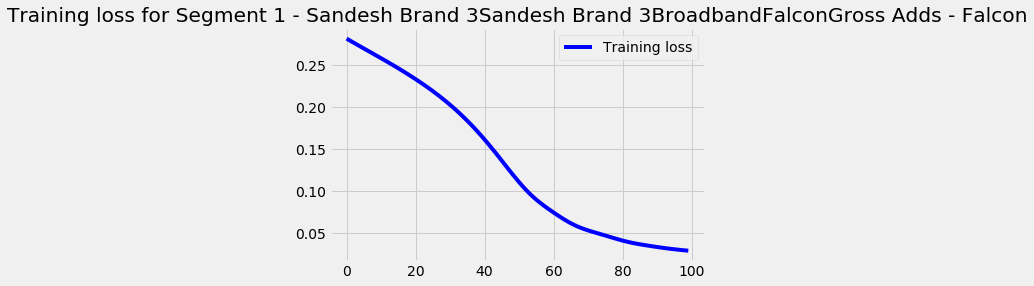

In [76]:
# plot trainning losses(0,1,2,3)
for i in range(len(df_rest.columns)-1):
    title = df_rest.columns[i]
    plot_train_history(models_history_rest[i], 'Training loss for {}'.format(title))

### Consolidate results and create output file

In [82]:
# consolidate : append in one list the generic variables with respect of their order in df 
lenght_col_rest = len(df_rest.columns)-1 #-1 for column price not included in generic variables
all_forcasts=forcast_rest.copy()
all_forcasts.append(forcast_tortoise_leavers[0])
all_forcasts.append(forcast_falcon_churn[0])

In [85]:
len(all_forcasts)

6

In [89]:
#check
columns_names=df.columns[:6]
columns_names

Index(['Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise',
       'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon'],
      dtype='object')

In [90]:
#Crearte output datafram and csv file
columns_names=df.columns[:6]
title_of_csv = 'Sandesh_3_Refinement_30_03_2020'
df_forcast = create_csv(all_forcasts, columns_names, title_of_csv, dir_path=dir_path )

,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon
Date,,,,,,
2019-04-01,-0.450974,0.689385,-0.219550,0.105016,0.295873,1.767649
2019-05-01,-1.609407,0.715714,-0.504155,0.725353,0.425967,2.342634
2019-06-01,-0.410709,0.395135,-0.278388,0.760091,0.329910,2.431668
2019-07-01,-0.302599,0.455297,0.143551,0.834898,0.384394,2.526295
2019-08-01,-0.861309,1.105913,-0.144198,0.450808,0.361629,1.253878
2019-09-01,-1.017358,1.061633,-0.426892,0.606907,0.417252,2.350315
2019-10-01,-1.161771,1.073137,-0.286070,1.004617,0.500989,3.420803
2019-11-01,-0.803786,1.446660,-0.206904,1.027933,0.342845,3.007984
2019-12-01,-0.402592,1.122774,-0.474753,0.746111,0.325125,3.123565
